# K2 ALGORITHM

## Inputs:
- A set of $n$ nodes
- An ordering on the nodes
- An upper bound $u$ on the number of parents a node may have
- A database $D$ containing m cases

## Outputs:
- For each node, a printout of the parents of the node

## Inputs:

In [1]:
# dataset
x1 <- c(1,1,0,1,0,0,1,0,1,0)    # classification target
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3 <- c(0,1,1,1,0,1,1,0,1,0)

names <- c("x1", "x2", "x3")    # names of the nodes

data <- data.frame(x1,x2,x3)
cat("DATABASE:\n\n")
print(data)

DATABASE:

   x1 x2 x3
1   1  0  0
2   1  1  1
3   0  0  1
4   1  1  1
5   0  0  0
6   0  1  1
7   1  1  1
8   0  0  0
9   1  1  1
10  0  0  0


In [2]:
n <- 3                          # number of nodes
order <- c(1,2,3)               # ordering on the nodes
u <- 2                          # upper bound on the number of parents

m <- length(x1)                 # number of cases

- $V_i$: list of all possible values of the attribute $x_i$
- $r_i$: |$V_i$|

In [3]:
# list of all possible values of the attribute xi
V <- list()

for (i in colnames(data)){
    categories <- sort(unique(data[[i]]))
    V <- c(V, list(categories))
}

# number of possible values for the attribute xi
r <- vector()
for (i in 1:length(V)){
    r <- c(r,length(V[[i]]))
}

## Useful functions:

- $\phi$: list of all possible instantiations of the parents of $x_i$ in database $D$
- $q_i$: |$\phi_i$|

In [4]:
# cartesian product for two or more lists
cartesian <- function(...) {
    axb <- expand.grid(...)
    axb <- axb[complete.cases(axb),]
    
    # order from first to last column
    for (j in ncol(axb):1){
        axb <- axb[order(axb[j]),]
    }
    
    return(as.matrix(axb))
}

# ph i: list of all possible instantiations of the parents of xi in the database
ph <- function(parents){
    if (length(parents) == 0){
        ph <- 0
    }
    else if (length(parents) == 1){
        ph <- t(t(V[[parents]]))   # in order to get a column vector
    }
    else{
        temp <- list()
        for (i in 1:length(parents)){
            temp <- c(temp, list(V[[parents[i]]]))
        }
        ph <- cartesian(temp)
    }
    
    return (ph)
}

# q: total number of possible instantiations of the parents of xi in the database
q <- function(parents){
    ifelse(length(parents)>0, nrow(ph(parents)), 0)
}

- $\alpha_{ijk}$: number of cases in $D$ in which the attribute $x_i$ is instantiated with its kth value, and the parents of $x_i$ in $\pi_i$ are instantiated with the jth instantiation in $\phi_i$
- $N_{ij}=\sum_{k=1}^{r_i}\alpha_{ijk} $: the number of instances in the database in which the parents of $x_i$ in $\pi_i$ are instantiated with the jth instantiation in $\phi_i$

In [5]:
# alpha i,j,k: number of cases in which:
# - xi attribute is instantiated with its k value
# - parents of xi are instantiated with its j value
alpha <- function(pi,i,j,k){
    phi <- ph(pi)
    
    # xi with its k value
    sub <- data[data[,i] == V[[i]][k], ]
    
    # parents of xi with its j value
    if(j>0){
        for (l in 1:length(pi)){
            sub <- sub[sub[,pi[l]] == phi[j,l], ]
        }
    }
    
    return(nrow(sub))
}

# N i,j: number of cases in which:
# - xi attribute is instantiated with its k value
# - parents of xi are instantiated with its j value
Nij <- function(pi,i,j){
    Nij <- 0
    for (k in 1:r[i]){
        Nij <- Nij + alpha(pi,i,j,k)
    }

    return(Nij)
}

- Pred($x_i$): a function that returns the set of nodes that precede $x_i$ in the node ordering

In [6]:
# Pred(xi): returns the set of nodes that precede xi
pred <- function(i){
    return (head(order, match(i,order)-1))
}

## $f(i,\pi_i)$: probability of the database $D$ given that the parents of $x_i$ are $\pi_i$

- $f(i,\pi_i) = \prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} \alpha_{ijk}!$

BUT in order to save run-time, we compute the logarithm of f(i,$\pi_i$)
- $\log[f(i,\pi_i)] =  \sum_{j=1}^{q_i} \log[(r_i-1)!] - \log[(N_{ij}+r_i-1)!] + \sum_{k=1}^{r_i} \log[\alpha_{ijk}!]$
$= \sum_{j=1}^{q_i} logfact[r_i-1] - logfact[N_{ij}+r_i-1] + \sum_{k=1}^{r_i} logfact[\alpha_{ijk}]$

In [7]:
# log(f(i,pi)) computation:
logf <- function(i, pi){
    qi <- q(pi)
    
    sum <- 0
    
    # If list of parents is not empty
    if(qi>0){
        for (j in 1:qi){
            for (k in 1:r[i]){
                aijk <- alpha(pi,i,j,k)
                sum <- sum + lfactorial(aijk)
            }
            nij <- Nij(pi,i,j)
            sum <- sum + lfactorial(r[i]-1) - lfactorial(nij + r[i]-1)
        }
    }
    # If list of parents is empty
    else{
        for (k in 1:r[i]){
            ai0k <- alpha(pi,i,0,k)
            sum <- sum + lfactorial(ai0k)
        }
        ni0 <- Nij(pi,i,0)
        sum <- sum + lfactorial(r[i]-1) - lfactorial(ni0 + r[i]-1)
    }
    
    return(sum)
}

# f(i,pi) computation
f <- function(i, pi){
    return (exp(logf(i, pi)))
}

## Network conditional probability: $\theta_{ijk} = p(x_i=\nu_{ik}|\pi_i=w_{ij})$
Probability that node $x_i$ has value $\nu_{ik}$ ($k$ from $1$ to $r_i$), given that the parents of $x_i$, represented by $\pi_i$, are instatiated as $w_{ij}$


In [8]:
# theta i,j,k computation:
theta <- function(pi,i){
    
    if (length(pi)==0){
        theta <- matrix(0, 1, (r[i]))
        for(k in 1:r[i]){
            theta[1,k]<-(alpha(pi,i,0,k)+1)/(Nij(pi,i,0)+r[i])
        }       
    }
    
    else{
        theta <- matrix(0, (r[i]),q(pi))
    for (j in 1:q(pi)){
        for(k in 1:r[i]){
            theta[k,j]<-(alpha(pi,i,j,k)+1)/(Nij(pi,i,j)+r[i])
        }
    }
}
    return(signif(theta,2))
}

# variance of theta i,j,k
var <- function(pi,i){
    
    if(length(pi)==0){
        var <- matrix(0, 1,(r[i]))
       
        for(k in 1:r[i]){
            var[1,k] <- ( (alpha(pi,i,0,k)+1) * (Nij(pi,i,0) + r[i] - alpha(pi,i,0,k)-1)) /
                        ( (Nij(pi,i,0) + r[i]+1) * (Nij(pi,i,0) + r[i])^2 ) 
        }
    
    }
    
    else{
        var <- matrix(0, (r[i]),q(pi))
    for (j in 1:q(pi)){
        for(k in 1:r[i]){
            var[k,j] <- ( (alpha(pi,i,j,k)+1) * (Nij(pi,i,j) + r[i] - alpha(pi,i,j,k)-1)) /
                        ( (Nij(pi,i,j) + r[i]+1) * (Nij(pi,i,j) + r[i])^2 ) 
        }
    }
        }
    
    return(signif(var,1))
}

# format to print theta i,j,k and its variance
theta.print <- function(pi,i){
    if (length(pi)==0){
         for(k in 1:r[i]){
                          cat( "P(",names[i],"=",V[[i]][k],
                    ") =",theta(pi,i)[1,k],"±", var(pi,i)[1,k] ,"\n")
    }

        }
    
    else { 
        for(j in 1:q(pi)){
            for(k in 1:r[i]){
                cat( "P(",names[i],"=",V[[i]][k],"|",names[pi],"=",ph(pi)[j,],
                    ") =",theta(pi,i)[k,j],"±", var(pi,i)[k,j] ,"\n")
            }
        }
    }
}

## K2 procedure
#### Greedy-search method to find the most probable belief-network structure
** We evaluate $log(f(i,\pi_i))$ insted of $f(i,\pi_i)$, in order to speed up the computation

In [9]:
# K2 algorithm:
# - return: adjacency matrix between all nodes (as a data frame)
K2 <- function(verbose=TRUE){
    cat("RUNNING K2 ALGORITHM\n\n")
    start.time <- Sys.time()
    
    adjMat <- matrix(0, n,n) # adjacency matrix initialization

    for (i in 1:n){
        pi <- vector()

        Pold <- logf(i,pi)
        OkToProceed <- TRUE

        while (OkToProceed & length(pi)<u){
            # z: node in Pred(xi) - PIi
            z <- pred(i)
            z <- z[! z %in% pi]

            # if Pred(xi) is empty -> iteration ends with pi = empty
            if (length(z)==0){
                OkToProceed = FALSE
                break
            }

            # find the node z that maximizes f(i, pi U z)
            Pnew <- -Inf
            newParent <- 0

            for(k in 1:length(z)){
                tempP <- logf(i, sort(c(pi,z[k])))
                if(tempP > Pnew){
                    Pnew <- tempP
                    newParent <- z[k]
                }
            }

            # if Pnew > Pold, add z to parents list
            # otherwise, iteration ends
            if(Pnew > Pold){
                Pold <- Pnew
                pi <- sort(c(pi, newParent))
                adjMat[newParent, i] <- 1
            }
            else{
                OkToProceed = FALSE
            }
        } # end while
        cat("Node:",i,", Parent of node",i,": ",pi,"\n")
        
        if (verbose==TRUE){
            cat(theta.print(pi,i),"\n")
        }
    }
    
    # add node names to adjacency matrix
    adjMat <- data.frame(adjMat)
    names(adjMat) <- names
    row.names(adjMat) <- names
    
    # print adjacency matrix
    if (verbose==TRUE){
        cat("\nAdjacency matrix:\n\n")
        print(adjMat)
    }
    
    end.time <- Sys.time()
    total.time <- end.time - start.time
    cat("\nTotal computation time:",total.time,"mins\n")
    
    return (adjMat)
}

## Run K2 algorithm

In [10]:
adjMatrix <- K2()

RUNNING K2 ALGORITHM

Node: 1 , Parent of node 1 :   
P( x1 = 0 ) = 0.5 ± 0.02 
P( x1 = 1 ) = 0.5 ± 0.02 
 
Node: 2 , Parent of node 2 :  1 
P( x2 = 0 | x1 = 0 ) = 0.71 ± 0.03 
P( x2 = 1 | x1 = 0 ) = 0.29 ± 0.03 
P( x2 = 0 | x1 = 1 ) = 0.29 ± 0.03 
P( x2 = 1 | x1 = 1 ) = 0.71 ± 0.03 
 
Node: 3 , Parent of node 3 :  2 
P( x3 = 0 | x2 = 0 ) = 0.71 ± 0.03 
P( x3 = 1 | x2 = 0 ) = 0.29 ± 0.03 
P( x3 = 0 | x2 = 1 ) = 0.14 ± 0.02 
P( x3 = 1 | x2 = 1 ) = 0.86 ± 0.02 
 

Adjacency matrix:

   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Total computation time: 0.1996291 mins


## K2 implementation with $bnstruct$ package

In [11]:
suppressWarnings(suppressMessages(library(Rgraphviz)))
suppressWarnings(suppressMessages(library(bnstruct)))

In [12]:
# BNDataset object creation
dataMat <- as.matrix(data)
dataset.from.data <- BNDataset(data = dataMat, discreteness = c('d','d','d'),
                               variables = names, node.sizes = r, starts.from=0)

# BN object creation
net <- BN(dataset.from.data)
# add the adjacency matrix to the BN object
dag(net) <- as.matrix(adjMatrix)

# print BN characteristics
#net

## Plot the network

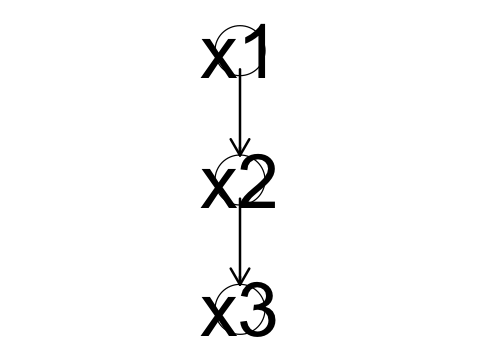

In [13]:
options(repr.plot.width=4, repr.plot.height=3)
plot(net)

## Try another algorithm with the previous database

In [14]:
# learn BN object
bnNet <- learn.network(dataset.from.data, algo="MMHC")

# print BN characteristics
bnNet

bnstruct :: learning the structure using MMHC ...
bnstruct :: learning using MMHC completed.
bnstruct :: learning network parameters ... 


node  1 
node  2 
node  3 


bnstruct :: parameter learning done.



Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  0  0
x2  1  0  0
x3  0  1  0

Conditional probability tables:$x1
   x1
x2          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x2
   x2
x3          1          2
  1 0.9444444 0.05555556
  2 0.1923077 0.80769231

$x3
x3
        1         2 
0.4090909 0.5909091 



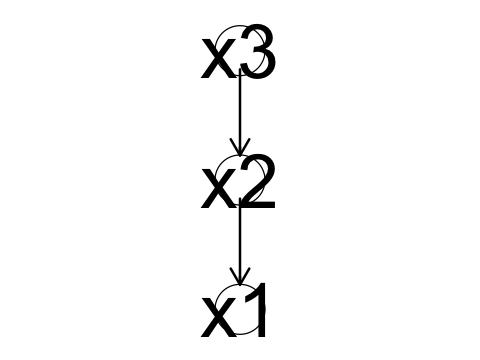

In [15]:
options(repr.plot.width=4, repr.plot.height=3)
plot(bnNet)

## Try the K2 algorithm with another database: ALARM dataset
- Dataset from http://www.openmarkov.org/learning/
- We use the node order specify in:
G. F. Cooper and E. Herskovits, $\textit{A Bayesian Method for the Induction of Probabilistic Networks from Data}$, Machine Learning 9, (1992) 309

In [16]:
data <- read.table("alarm10kOk.csv", header = TRUE, sep = ";", quote = " \ ")

cat("DATABASE:\n\n")
data

DATABASE:



CVP,PCWP,HISTORY,TPR,BP,CO,HRBP,HREKG,HRSAT,PAP,⋯,ERR4OUTPUT,HR,ERRCAUTER,SHUNT,PVSAT,ARTCO2,VENTALV,VENTLUNG,VENTTUBE,VENTMACH
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,2,1,3,4,4,3,2,2,3,⋯,0,2,1,3,4,2,5,5,4,3
2,2,1,3,4,4,2,2,2,3,⋯,1,2,1,3,4,2,5,5,4,3
2,2,1,2,3,2,2,2,2,3,⋯,1,2,1,3,4,2,5,5,4,3
2,2,1,2,3,4,2,2,2,3,⋯,1,2,1,2,4,2,5,5,4,3
2,2,1,4,3,2,2,2,2,3,⋯,1,2,1,3,2,4,2,4,5,3
2,3,1,4,4,4,2,2,2,3,⋯,1,2,1,3,4,2,5,5,4,3
2,2,1,3,2,3,2,2,2,3,⋯,1,2,1,3,4,3,3,3,4,3
2,2,1,2,2,3,4,4,3,3,⋯,1,3,0,3,2,4,2,4,5,3
2,2,1,3,3,3,2,2,2,3,⋯,1,2,1,3,4,2,5,5,4,3


In [17]:
# list of all possible values of the attribute xi
V <- list()

for (i in colnames(data)){
    categories <- sort(unique(data[[i]]))
    V <- c(V, list(categories))
}

# number of possible values for the attribute xi
r <- vector()
for (i in 1:length(V)){
    r <- c(r,length(V[[i]]))
}

In [18]:
n <- 37                                              # number of nodes
order <- c(12,16,17,18,19,20,21,22,23,24,25,26,28,
           30,31,37,1,2,3,4,10,36,13,35,15,34,32,33,
           11,14,27,29,6,7,8,9,5)                    # ordering on the nodes
u <- 5                                               # upper bound on the number of parents

m <- length(data$HISTORY)                            # number of cases

names <- as.character(1:n)                           # names of the nodes

In [19]:
adjMatrix <- K2(verbose=FALSE)

RUNNING K2 ALGORITHM

Node: 1 , Parent of node 1 :  25 
Node: 2 , Parent of node 2 :  25 
Node: 3 , Parent of node 3 :  18 
Node: 4 , Parent of node 4 :  19 
Node: 5 , Parent of node 5 :  4 6 
Node: 6 , Parent of node 6 :  26 29 
Node: 7 , Parent of node 7 :  28 29 
Node: 8 , Parent of node 8 :  29 30 
Node: 9 , Parent of node 9 :  8 29 30 
Node: 10 , Parent of node 10 :  21 
Node: 11 , Parent of node 11 :  31 32 
Node: 12 , Parent of node 12 :   
Node: 13 , Parent of node 13 :  22 23 36 
Node: 14 , Parent of node 14 :  33 35 
Node: 15 , Parent of node 15 :  22 35 
Node: 16 , Parent of node 16 :   
Node: 17 , Parent of node 17 :   
Node: 18 , Parent of node 18 :   
Node: 19 , Parent of node 19 :   
Node: 20 , Parent of node 20 :   
Node: 21 , Parent of node 21 :   
Node: 22 , Parent of node 22 :   
Node: 23 , Parent of node 23 :   
Node: 24 , Parent of node 24 :   
Node: 25 , Parent of node 25 :  17 18 
Node: 26 , Parent of node 26 :  17 18 25 
Node: 27 , Parent of node 27 :  4 11 33 


In [20]:
# BNDataset object creation
dataMat <- as.matrix(data)
dataset.from.data <- BNDataset(data = dataMat, discreteness = rep('d',n), variables = names, node.sizes = rep(8,n), starts.from=0)

# BN object creation
alarmNet <- BN(dataset.from.data)
# add the adjacency matrix to the BN object
dag(alarmNet) <- as.matrix(adjMatrix)

# print BN characteristics
#net

Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37”

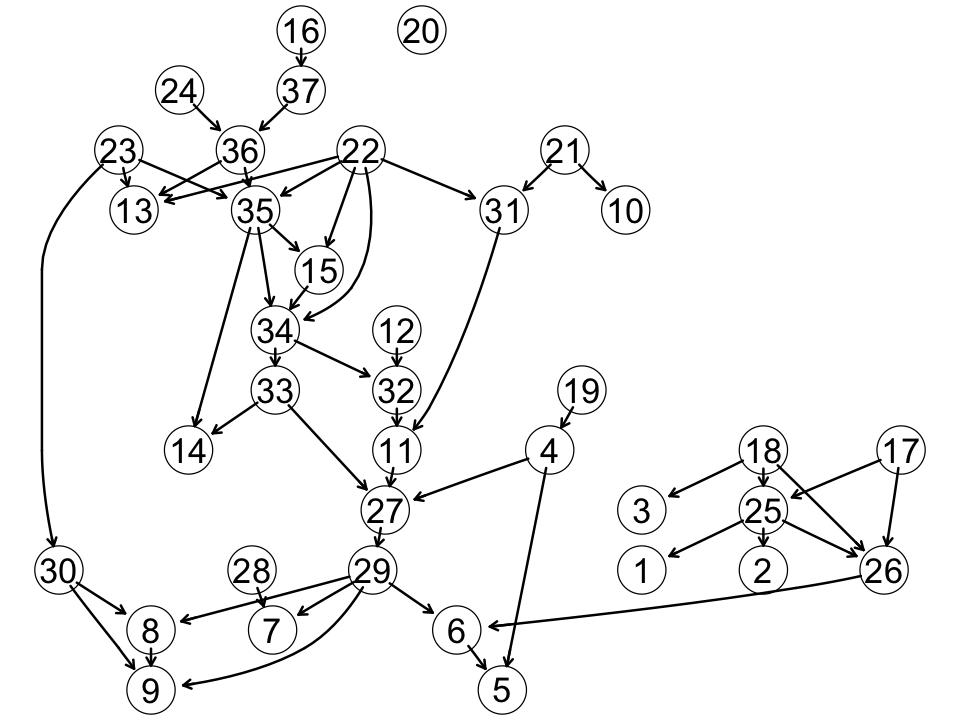

In [21]:
options(repr.plot.width=8, repr.plot.height=6)
plot(alarmNet)